In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import datetime
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from tqdm import tqdm_notebook
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### data 불러오기

In [2]:
Y_가전제품 = pd.read_csv('Y_가전제품.csv')
Y_화장품 = pd.read_csv('Y_화장품.csv')
Y_패션 = pd.read_csv('Y_패션.csv')

In [3]:
Y_가전제품= Y_가전제품['가전제품구매']
Y_화장품= Y_화장품['화장품구매']
Y_패션= Y_패션['패션구매']

In [4]:
X_가전제품 = pd.read_csv('가전제품_3d_array.csv')
X_화장품 = pd.read_csv('화장품_3d_array.csv')
X_패션 = pd.read_csv('패션_3d_array.csv')

In [5]:
X_가전제품 = np.asarray(X_가전제품)
X_화장품 = np.asarray(X_화장품)
X_패션 = np.asarray(X_패션)

### Oversampling

In [6]:
X_가전제품.shape

(2103, 80000)

In [7]:
smote = SMOTE()

In [8]:
def oversample(X, Y):
    max_len = 5000
    X_resampled, Y_resampled = smote.fit_resample(X, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, int(X_resampled.shape[1]/max_len))
    return X_resampled, Y_resampled

In [9]:
X_가전제품_resampled, Y_가전제품_resampled =oversample(X_가전제품, Y_가전제품)
X_패션_resampled, Y_패션_resampled = oversample(X_패션, Y_패션)
X_화장품_resampled, Y_화장품_resampled = oversample(X_화장품, Y_화장품)

### LSTM 가동

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 패션

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
X_패션_resampled, Y_패션_resampled, test_size=0.3, random_state=42)

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
X_train.shape

(3790, 5000, 16)

In [14]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

W0114 13:37:07.790207 140181705480000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0114 13:37:07.805617 140181705480000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:492: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0114 13:37:07.809621 140181705480000 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1359: calling reduce_any_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0114 13:37:07.814324 140181705480000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3630: The name tf.random

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5000, 16)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 23,395
Trainable params: 23,395
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

W0114 13:37:08.397533 140181705480000 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:675: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0114 13:37:08.414020 140181705480000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:953: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3790 samples, validate on 1625 samples
Epoch 1/30
 - 122s - loss: 1.0729 - acc: 0.3501 - val_loss: 1.0662 - val_acc: 0.3483
Epoch 2/30
 - 106s - loss: 1.0318 - acc: 0.4121 - val_loss: 1.0991 - val_acc: 0.3471
Epoch 3/30
 - 115s - loss: 1.0169 - acc: 0.4580 - val_loss: 1.0196 - val_acc: 0.5151
Epoch 4/30
 - 120s - loss: 0.9712 - acc: 0.5198 - val_loss: 1.0511 - val_acc: 0.4468
Epoch 5/30
 - 120s - loss: 0.9873 - acc: 0.5135 - val_loss: 1.0000 - val_acc: 0.5662
Epoch 6/30
 - 118s - loss: 0.9403 - acc: 0.5884 - val_loss: 0.9302 - val_acc: 0.5945
Epoch 7/30
 - 107s - loss: 0.9789 - acc: 0.5361 - val_loss: 0.9498 - val_acc: 0.5514
Epoch 8/30
 - 119s - loss: 0.9227 - acc: 0.6066 - val_loss: 1.4886 - val_acc: 0.3625
Epoch 9/30
 - 107s - loss: 0.9834 - acc: 0.5963 - val_loss: 0.9217 - val_acc: 0.6191
Epoch 10/30
 - 114s - loss: 0.9013 - acc: 0.6356 - val_loss: 0.9037 - val_acc: 0.6332
Epoch 11/30
 - 119s - loss: 0.9073 - acc: 0.6282 - val_loss: 0.8889 - val_acc: 0.6357
Epoch 12/30
 - 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
#가전제품 f1-score: 0.7819220343082984
#패션 accuracy: 0.7188029361269287

print(accuracy)

#### 가전제품

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
X_가전제품_resampled, Y_가전제품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

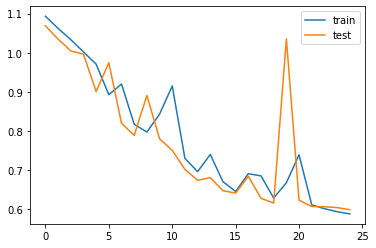

In [52]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()                       

In [53]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [56]:
#가전제품 f1-score: 0.7819220343082984

print(accuracy)

0.7188029361269287


#### 화장품

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
X_화장품_resampled, Y_화장품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [58]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 5000, 16)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 23,395
Trainable params: 23,395
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 3916 samples, validate on 1679 samples
Epoch 1/50
 - 51s - loss: 0.6749 - acc: 0.6338 - val_loss: 0.6493 - val_acc: 0.6367
Epoch 2/50
 - 51s - loss: 0.6732 - acc: 0.6404 - val_loss: 0.6465 - val_acc: 0.6355
Epoch 3/50
 - 52s - loss: 0.6689 - acc: 0.6456 - val_loss: 0.6563 - val_acc: 0.6403
Epoch 4/50
 - 51s - loss: 0.6811 - acc: 0.6369 - val_loss: 0.6383 - val_acc: 0.6504
Epoch 5/50
 - 51s - loss: 0.6599 - acc: 0.6435 - val_loss: 0.6382 - val_acc: 0.6403
Epoch 6/50
 - 51s - loss: 0.7159 - acc: 0.6353 - val_loss: 0.9163 - val_acc: 0.5789
Epoch 7/50
 - 52s - loss: 0.8036 - acc: 0.5858 - val_loss: 0.6506 - val_acc: 0.6397
Epoch 8/50
 - 51s - loss: 0.6615 - acc: 0.6417 - val_loss: 0.6379 - val_acc: 0.6498
Epoch 9/50
 - 51s - loss: 0.6544 - acc: 0.6468 - val_loss: 0.6329 - val_acc: 0.6546
Epoch 10/50
 - 51s - loss: 0.6560 - acc: 0.6394 - val_loss: 0.6314 - val_acc: 0.6528
Epoch 11/50
 - 51s - loss: 0.6553 - acc: 0.6453 - val_loss: 0.6297 - val_acc: 0.6546
Epoch 12/50
 - 54s - loss: